# **선박해양생산공학 Assignment 2**
블록 조립 공정 데이터와 머신 러닝을 이용한 작업 시간 예측

작성자: *2018-15872 박동인*



# Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
!git clone https://github.com/doyle34/SNU_SPM_ML.git

Cloning into 'SNU_SPM_ML'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


# 1 Read Data

csv 파일을 읽고 ```pandas.DataFrame``` 형식으로 저장한다.

In [3]:
csv_pd = pd.read_csv('/content/SNU_SPM_ML/DSME_assembly.csv', delimiter=',')
csv_pd.head()

,Unnamed: 0,공사번호,블록,공정,블록타입,선종,BLK_WT,BLK_LNTH,BLK_BDTH,BLK_HGHT,PCGCODE,송선,SHOP,사내외,P_LT,LT
0,0,2431,131,조립,BLK,LNGC,290,15.6,18.6,7.3,EB1,C1E1,CAS,사내,100,12
1,1,2431,121,조립,BLK,LNGC,275,15.6,17.8,7.3,EB1,C1E1,CAS,사내,102,12
2,2,2431,132,조립,BLK,LNGC,176,15.6,24.9,4.3,EL1,SCP1,PAS,사내,64,19
3,3,2431,801,조립,BLK,LNGC,222,12.6,19.3,3.2,FB1,C1S4,CAS,사내,87,17
4,4,2431,832,조립,BLK,LNGC,268,19.2,18.9,7.9,FL1,SCE1,GBS,사내,87,11


# 2 Data Preprocessing





## 2.1 One Hot Encoding

모델 학습에 쓰일 데이터에는 숫자만 포함될 수 있다. 그러나 '공정', '선종', '송선'과 같은 데이터는 값이 문자열이므로 이들을 숫자 형식으로 바꾸어 주는 과정이 필요하다. 이와 같은 categorical feature를 numerical feature로 바꾸는 방식에는 여러 방법이 있는데, 대표적으로 label encoding과 one-hot encoding이 있다. Label encoding은 문자열들에 순서를 부여할 수 있을 때 주로 사용된다. 예를 들면 ``` ['first', 'second', 'third'] ``` 와 같은 데이터는 label encoding이 효과적이다. 반대로 문자열이 순서를 부여하기 어렵고 독립적인 의미를 가진다면 one-hot encoding이 효율적이다. 이번 과제에 쓰이는 데이터는 모두 순서 부여가 어려우므로 one-hot encoding이 효율적이다. ``` pandas ```의 ```get_dummies()```함수는 주어진 ```Dataframe```에 자동으로 one-hot encoding을 해 준다.






In [4]:
# one hot encoding
print('number of features in original data: %i' % len(csv_pd.columns))
csv_pd_dummies = pd.get_dummies(csv_pd)
print('number of features after one-hot encoding: %i' % len(csv_pd_dummies.columns))

number of features in original data: 16
number of features after one-hot encoding: 217


## 2.2 Remove Outliers
LT 데이터의 경우 0 이하의 값을 가지는 데이터를 제거해 주는 과정이 필요하지만 PLT 데이터의 경우에는 모든 데이터를 사용할 수 있다. 따라서 두 데이터의 샘플 크기가 달라지게 된다. csv 파일에서 읽어온 데이터 중 PLT, LT에 해당하는 열(output, target 또는 label data)을 각각 ```y_PLT```, ```y_LT```로 저장하고 이에 해당하는 나머지 열(input data)을 각각 ```X_PLT```, ```X_LT```로 저장한다. 이 코드에서는 일관적으로 input data는 ```X```로, output data는 ```y```로 표기한다.

number of sample data for P_LT prediction: 7618
number of sample data for LT prediction: 7542


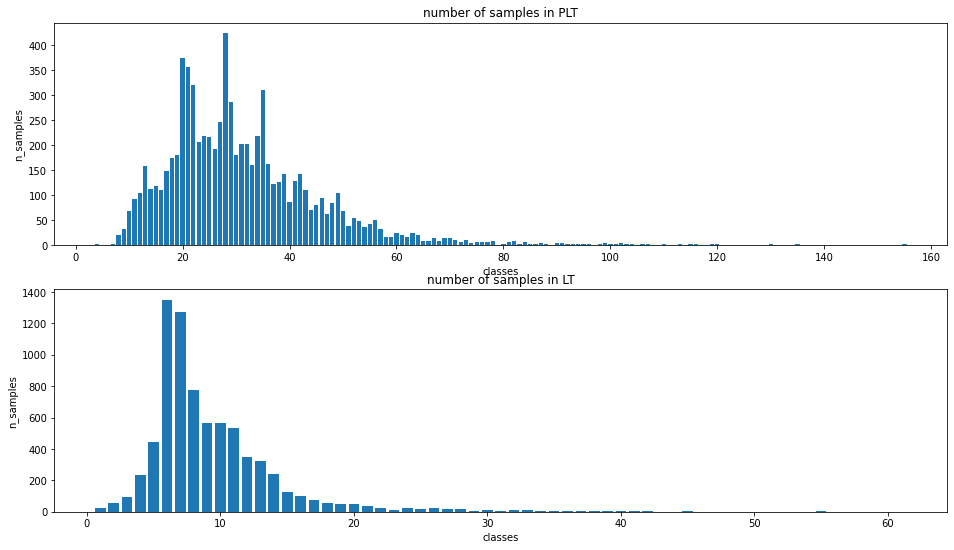

In [5]:
y_PLT = csv_pd_dummies['P_LT'].to_numpy()
X_PLT = csv_pd_dummies.drop(columns=['Unnamed: 0', 'P_LT', 'LT']).to_numpy()
feature_names = list(csv_pd_dummies.drop(columns=['Unnamed: 0', 'P_LT', 'LT']).columns)

# remove ouliers which LT <= 0
csv_pd_dummies = csv_pd_dummies.loc[csv_pd_dummies['LT'] > 0, :]
y_LT = csv_pd_dummies['LT'].to_numpy()
X_LT = csv_pd_dummies.drop(columns=['Unnamed: 0', 'P_LT', 'LT']).to_numpy()

print('number of sample data for P_LT prediction: %i' % len(X_PLT))
print('number of sample data for LT prediction: %i' % len(X_LT))

fig, axes = plt.subplots(2, 1, figsize=(16,9))

for ax, y, name in zip(axes.ravel(), [y_PLT, y_LT], ['PLT', 'LT']):
    values, counts = np.unique(y, return_counts=True)
    ax.bar(values, counts)
    ax.set_title('number of samples in %s' % name)
    ax.set_xlabel('classes')
    ax.set_ylabel('n_samples')

plt.show()

## 2.3 Split Train Set and Test Set
[scikit-learn User Guide: 3.1. Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

일반적으로 머신러닝에서는 모델이 주어진 데이터만 정확히 예측하고 다른 데이터는 정확하게 예측하지 못하는 overfitting 현상을 방지하기 위해 데이터셋을 train set과 test set으로 나누어서 train set을 사용하여 모델을 학습시키고 test set으로 모델을 평가한다. 보통 test set의 예측을 정확하게 하기 위해 모델의 hyperparameter를 임의로 바꾸어가며 실험하게 되는데, 이 경우 train set이 아닌 test set의 특성이 모델에 반영되게 된다. 이 문제를 해결하기 위해 train set에서 validation set을 추출해서 validation set으로 최적의 hyperparameter를 추정하고 최종적으로 test set으로 모델을 평가할 수 있다. 하지만 이 경우에 데이터셋이 나누어지기 때문에 모델 학습에 쓰일 train set의 개수가 적어져 underfitting이 될 수 있다.

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width=500/>

이 문제를 해결하는 제일 좋은 방법은 교차 검증(cross-validation, 줄여서 CV)이다. 보편적인 CV 방법 중 하나인 k-fold CV는 train set을 k개로 분할(fold)하고 그 중 하나의 fold를 validation set으로, 나머지 fold를 train set으로 정하여 모델을 여러 번 반복하여 학습시켜 최적의 hyperparameter를 찾고 최종적으로 test set으로 검증하는 방법이다.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=500/>


[scikit-learn User Guide: 3.2.1. Exhaustive Grid Search](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search)

모델의 hyperparameter를 쉽게 찾는 방법으로 grid search 방법이 있다. 이 중 제일 단순한 exhaustive grid search는 모델의 hyperparameter들을 격자 모양의 배열로 만든 뒤 각 cell에 해당하는 hyperparameter로 모델을 훈련시키는 과정을 반복하는 것이다.

<img src="https://miro.medium.com/max/648/1*wGWTup9r4cVytB5MOnsjdQ.png" width=500/>


```scikit-learn```의 ```train_test_split``` 함수는 train set과 test set을 나누어주고, ```GridSearchCV``` 함수는 exhaustive grid search와 cross validation을 동시에 진행해 최적의 hyperparameter를 찾아준다.

In [6]:
# split train and test set
X_LT_train, X_LT_test, y_LT_train, y_LT_test = train_test_split(X_LT, y_LT, test_size=0.3, random_state=0)
X_PLT_train, X_PLT_test, y_PLT_train, y_PLT_test = train_test_split(X_PLT, y_PLT, test_size=0.3, random_state=0)
X_trains = [X_LT_train, X_PLT_train]
y_trains = [y_LT_train, y_PLT_train]
X_tests = [X_LT_test, X_PLT_test]
y_tests = [y_LT_test, y_PLT_test]

## 2.4 Principal Component Analysis

2.1절에서 one-hot encoding된 train set의 feature 개수는 214개임을 알 수 있다. 그러나 이들 특성 모두가 모델의 parameter estimation에 중요한 역할을 하는 것은 아니다. input data에서 중요한 feature들을 뽑아서 개수를 줄이면 모델이 더 간결해지고 계산 속도도 빨라진다. 대표적으로 주성분 분석(Principal Component Analysis, 줄여서 PCA)이 있는데 이는 input data ```X```의 eigenvector를 찾아서 orthogonal component로 표현하는 방법이다. 예를 들어 ```X_PLT_train```을 3개의 주성분으로 표현한 결과는 다음과 같다.



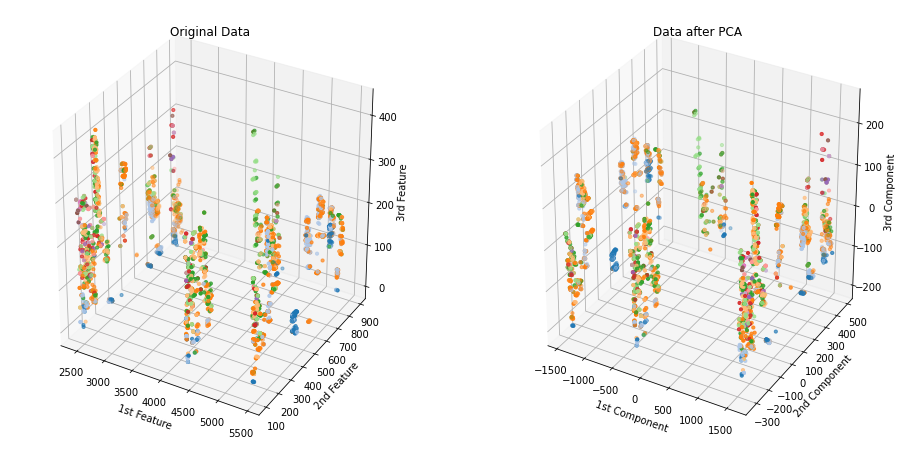

In [7]:
# PCA (Principal Component Analysis)
pca = PCA(n_components=3)
X_PLT_pca = pca.fit_transform(X_PLT_train)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X_PLT_train[:, 0], X_PLT_train[:, 1], X_PLT_train[:, 2], s=10, c=y_PLT_train, cmap='tab20')
ax.set_title("Original Data")
ax.set_xlabel("1st Feature")
ax.set_ylabel("2nd Feature")
ax.set_zlabel("3rd Feature")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X_PLT_pca[:, 0], X_PLT_pca[:, 1], X_PLT_pca[:, 2], s=10, c=y_PLT_train, cmap='tab20')
ax.set_title("Data after PCA")
ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.set_zlabel("3rd Component")

plt.show()

# 3 Model Training: Random Forest Classifier

[scikit-learn User Guide 1.11.2. Forests of randomized trees](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn-ensemble-randomforestclassifier)

데이터 전처리를 끝냈으므로 모델을 학습시킬 차례이다. 이번 과제는 지도 다중 클래스 분류(Supervised Multi-class Classification) 문제로 생각할 수 있는데, 여러 분류기 중 랜덤 포레스트 분류기(Random Forest Classifier, 줄여서 RFC)를 이용한다. RFC는 여러 결정 트리(Decision Tree)들의 분류 결과의 평균을 통해 최종 예측을 수행하는 모델로써 결정 트리에 비해 overfitting이 일어날 가능성이 적다. <br/> 
 RFC의 hyperparameter로는 여러 가지가 있지만 이번 과제에서 사용하는 hyperparameter는 다음과 같다. <br/>

 * ```n_estimators```: RFC를 이루는 결정 트리의 개수
 * ```max_depth```: 각 결정 트리의 최대 깊이. 이번 과제에서는 ```max_depth=10```으로 고정한다.
 * ```class_weight```: 각 class의 가중치 옵션. ```'balanced'``` 옵션은 class의 빈도수에 반비례하는 가중치를 생성한다. 즉 sample 개수가 적은 class일수록 가중치가 크다. class 별로 sample들의 개수가 크게 차이나는 데이터셋의 특징에 잘 어울린다.<br/>



## 3.1 Grid Search & Cross Validation

앞서 설명한 방식대로 ```GridSearchCV``` 함수를 이용해 exhaustive grid search와 cross validation를 동시에 수행한다. grid search의 대상이 되는 hyperparameter는 다음과 같다.
* ```PCA__n_components```: PCA의 orthogonal component 개수. [20, 30, 40, 50]
* ```clf__n_estimators```: RFC의 결정 트리 개수, [50, 100, 200, 250]
<br/>

따라서 총 16개의 조합에 대해 grid search와 cross validation을 수행하고 CV score가 가장 높은 best parameter 조합을 찾는다.

In [8]:
# Grid Search & Cross Validation
pcas = [PCA() for i in range(2)]
clfs = [RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced') for i in range(2)]
pipes = [Pipeline(steps=[('pca', pca), ('clf', clf)]) for pca, clf in zip(pcas, clfs)]
param_grid = {
    'pca__n_components': [20, 30, 40, 50],
    'clf__n_estimators': [50, 100, 200, 250],
}
searches = [GridSearchCV(pipe, param_grid, n_jobs=-1) for pipe in pipes]
n_comps = []
n_esties = []
for search, X_train, y_train, label in zip(searches, X_trains, y_trains, ['LT', 'P_LT']):
    search.fit(X_train, y_train)
    print("Best parameter for %s classification (CV score=%.3f):" % (label, search.best_score_))
    print(search.best_params_)
    n_comps.append(search.best_params_['pca__n_components'])
    n_esties.append(search.best_params_['clf__n_estimators'])


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameter for LT classification (CV score=0.157):
{'clf__n_estimators': 200, 'pca__n_components': 20}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameter for P_LT classification (CV score=0.118):
{'clf__n_estimators': 250, 'pca__n_components': 30}


## 3.2 Train Model with Best Parameters

최적의 hyperparameter를 찾았으므로 이를 사용하여 모델을 fitting한다. 2.3에서 설명했듯이 train set의 k-fold CV를 통해 모델을 훈련한다. ```StratifiedKFold``` 함수는 주어진 train set을 ```n_splits``` 개수의 fold로 반복 분할한다. 각 과정에서 train accuracy, validation accuracy, RMSE, MAE를 계산하여 저장한다. 평가 방법에 대한 자세한 설명은 4절에서 다룬다. 다음은 LT, P_LT 데이터에 대한 분류를 차례대로 수행하는 과정이다.


In [9]:
# Re-define Model with best parameters
pcas = [PCA(n_components=n) for n in n_comps]
clfs = [RandomForestClassifier(n_estimators=n, max_depth=10, random_state=0, class_weight='balanced') for n in n_esties]

In [10]:
# Retrain Model with best parameters
pca_components = []
n_features = []
feature_importances = []
acc = []
RMSE = []
MAE = []
acc_valid = []
RMSE_valid = []
MAE_valid = []
for i, (pca, clf, X_train, y_train, X_test, y_test, label) in enumerate(zip(pcas, clfs, X_trains, y_trains, X_tests, y_tests, ['LT', 'P_LT'])):
    X_pca = pca.fit_transform(X_train)
    pca_components.append(pca.components_)
    skf = StratifiedKFold(n_splits=5)
    acc_tmp = []
    RMSE_tmp = []
    MAE_tmp = []
    print('Classification for %s\n' % label)
    for train_index, valid_index in skf.split(X_pca, y_train):
        X_ftrain, X_valid = X_pca[train_index], X_pca[valid_index]
        y_ftrain, y_valid = y_train[train_index], y_train[valid_index]
        clf.fit(X_ftrain, y_ftrain)
        print('train -  {}   |   validation -  {}'.format(len(y_train[train_index]), len(y_train[valid_index])))
        print("train accuracy: %.3f\n" % clf.score(X_ftrain, y_ftrain))
        y_pred = clf.predict(X_valid)
        acc_tmp.append(clf.score(X_valid, y_valid))
        RMSE_tmp.append(mean_squared_error(y_valid, y_pred, squared=False))
        MAE_tmp.append(mean_absolute_error(y_valid, y_pred))
    
    n_features.append(clf.n_features_)
    feature_importances.append(clf.feature_importances_)
    
    # Validation Result
    acc_valid.append(max(acc_tmp))
    RMSE_valid.append(min(RMSE_tmp))
    MAE_valid.append(min(MAE_tmp))
    print("maximum validation accuracy: %.3f" % acc_valid[i])
    print('minimum validation RMSE: %.2f' % RMSE_valid[i])
    print('minimum validation MAE: %.2f\n' % MAE_valid[i])

    # Test Result
    X_test_pca = pca.fit_transform(X_test)
    y_pred = clf.predict(X_test_pca)
    acc.append(clf.score(X_test_pca, y_test))
    RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
    MAE.append(mean_absolute_error(y_test, y_pred))
    print("test accuracy: %.3f" % acc[i])
    print('test RMSE: %.2f' % RMSE[i])
    print('test MAE: %.2f\n' % MAE[i])

Classification for LT



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train -  4223   |   validation -  1056
train accuracy: 0.567

train -  4223   |   validation -  1056
train accuracy: 0.562

train -  4223   |   validation -  1056
train accuracy: 0.547

train -  4223   |   validation -  1056
train accuracy: 0.559

train -  4224   |   validation -  1055
train accuracy: 0.546

maximum validation accuracy: 0.170
minimum validation RMSE: 5.66
minimum validation MAE: 3.79

test accuracy: 0.152
test RMSE: 6.57
test MAE: 4.25

Classification for P_LT



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train -  4265   |   validation -  1067
train accuracy: 0.490

train -  4265   |   validation -  1067
train accuracy: 0.497

train -  4266   |   validation -  1066
train accuracy: 0.499

train -  4266   |   validation -  1066
train accuracy: 0.503

train -  4266   |   validation -  1066
train accuracy: 0.488

maximum validation accuracy: 0.126
minimum validation RMSE: 11.52
minimum validation MAE: 7.48

test accuracy: 0.059
test RMSE: 23.59
test MAE: 16.53



# 4 Model Evaluation
[scikit-learn User Guide 3.3. Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions)


이번 과제에서 모델의 평가는 MAE(Mean Absolute Error)와 RMSE(Root Mean Squared Error)로 수행한다. MAE와 RMSE는 다음과 같이 정의된다.

> $\text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$ <br/> <br/>
$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2$ <br/> <br/>
$\text{RMSE}(y, \hat{y}) = \sqrt{\text{MSE}(y, \hat{y})}$


추가적으로 고려할 만한 평가 방법은 accuracy이다. 분류 문제에서 accuracy는 모델이 예측한 label과 실제 label이 일치하는 비율을 의미하고 정의는 다음과 같다.

> $\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$

LT와 P_LT에 대해 test accuracy, MAE, RMSE를 정리하면 다음과 같다.



In [11]:
eval_data = pd.DataFrame(data=np.transpose([acc, MAE, RMSE]), index=['LT', 'P_LT'], columns=['Accuracy', 'MAE', 'RMSE'])
eval_data.round(3).head()

,Accuracy,MAE,RMSE
LT,0.152,4.250,6.566
P_LT,0.059,16.525,23.593


LT와 P_LT에 대해 validation과 test의 결과를 비교했다. LT의 경우 비교적 validation과 test의 차이가 작지만 P_LT의 경우 차이가 매우 큰 것을 볼 수 있다. P_LT의 경우에 overfitting이 더 강하게 일어났음을 알 수 있다.

In [12]:
compare_data = pd.DataFrame(data=np.transpose([acc_valid, acc, MAE_valid, MAE, RMSE_valid, RMSE]), index=['LT', 'P_LT'],
                            columns=['Max Validation Accuracy', 'Test Accuracy', 'Min Validation MAE', 'Test MAE', 
                                     'Min Validation RMSE', 'Test RMSE'])
compare_data.round(3).head()

,Max Validation Accuracy,Test Accuracy,Min Validation MAE,Test MAE,Min Validation RMSE,Test RMSE
LT,0.170,0.152,3.790,4.250,5.663,6.566
P_LT,0.126,0.059,7.484,16.525,11.522,23.593


RFC 모델의 평가 방법 중 하나로 트리의 ```feature_importances_```를 확인하는 방법이 있다. 이 변수는 RFC의 분류 과정에서 각 feature가 분류에 끼친 영향을 0부터 1의 값으로 나타낸 것이다. 0은 해당 feature가 분류에 전혀 영향을 끼치지 않았음을 의미하고 1은 해당 feature가 데이터셋을 완벽히 분류했음을 의미한다.

그러나 데이터셋이 PCA를 통해 주성분으로 표현되었기 때문에 ```feature_importances_```는 ```(n_components, 1)```의 shape을 가진다. 즉 ```feature_importances_```를 통해 영향력이 높은 component는 알 수 있지만 영향력이 높은 feature를 확인할 수는 없다. 진짜 feature importance를 추정하기 위해서는 component space의 벡터를 feature space의 벡터로 변환해야 하는데, 이는 ```PCA```의 ```inverse_transform```함수를 통해 수행할 수 있다.

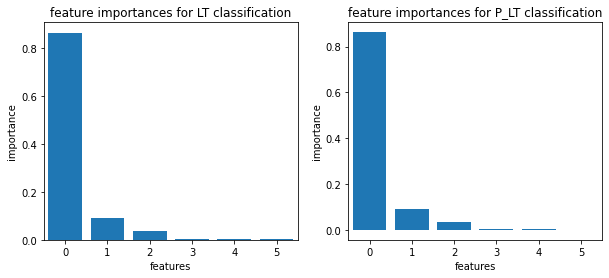

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

for ax, pca, fi, label in zip(axes.ravel(), pcas, feature_importances ,['LT','P_LT']):
    feature_inv = pca.inverse_transform(fi)
    ax.bar(range(len(feature_names)), feature_inv / sum(feature_inv))
    ax.set_title('feature importances for %s classification' % label)
    ax.set_xlabel('features')
    ax.set_ylabel('importance')
    ax.set_xlim(-0.5, 5.5)

plt.show()

LT와 P_LT 모두 분류 과정에서 0번째 feature, 즉 '공사번호' 특성이 가장 많은 영향력을 가졌음을 알 수 있다. 다만 이는 PCA 변환과 역변환을 하는 과정에서 '공사번호' 특성의 중요도가 매우 높아진 것으로 생각되며, 만약 PCA 변환이 없었다면 실제 중요도는 이보다 낮을 것으로 생각된다.

# 5 Conclusion
RFC 모델을 통해 블록 조립 공정 데이터를 이용해 작업 시간을 예측하였다. Grid Search를 수행하여 train set에 PCA의 component 개수과 RFC 트리의 개수의 최적의 조합을 찾고 모델을 훈련시켰다. 그 결과 LT의 경우가 P_LT의 경우보다 overfitting이 적게 일어났으나 두 모델 모두 정확도가 높은 편은 아니다. RFC의 특성 중요도를 검토한 결과 '공사번호' 특성이 가장 분류에 큰 영향을 끼쳤다.

# References

> Müller, A. C., & Guido, S. (2017). *Introduction to machine learning with Python: A guide for data scientists.*